## Install software
Please make sure you only run this cell at the correct stage of the setup. 

You can run a code cells by bringing it into focus (e.g. clicking in it) and pressing "ctrl+Enter".

In [ ]:
import sys
!python -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!python -m pip install pandas
!python -m pip install -U scikit-learn
!python -m pip install -U matplotlib
!python -m pip install opencv-contrib-python

## Unzip data
The data files you downloaded are compressed as a zip file. Run the following code cell to unzip them so that the data can be imported.

In [ ]:
!PowerShell.exe -Command "Expand-Archive -Path \"\\smbhome.uscs.susx.ac.uk\jb739\Desktop\work_experience\face_images.npz.zip\" -DestinationPath \"\\smbhome.uscs.susx.ac.uk\jb739\Desktop\work_experience\\""
!PowerShell.exe -Command "Expand-Archive -Path \"\\smbhome.uscs.susx.ac.uk\jb739\Desktop\work_experience\facial_keypoints.csv.zip\" -DestinationPath \"\\smbhome.uscs.susx.ac.uk\jb739\Desktop\work_experience\\""

## Set hyperparameters

In [58]:
### Parameters to be modified
batchSize = 32
nFeatures = 4
learningRate = 0.01
weightDecay = 0.0001
num_epochs = 10
trainSplit = 0.1

## Import libraries

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import cv2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Load data

In [60]:
# Load and preprocess data
npz_file = './face_images.npz'
csv_file = './facial_keypoints.csv'

data = np.load(npz_file)
images = data['face_images']  # assuming images are stored under 'images' key
coordinates = np.array(pd.read_csv(csv_file).values)

# Reshape image data
images = np.transpose(images, (2, 0, 1))

# Find samples that have at coordinates for centres of both eyes
keep_ix = np.logical_not(np.isnan(coordinates[:,:nFeatures])).all(axis=1)
images = images[keep_ix,:]
coordinates = coordinates[keep_ix,:nFeatures]

# Normalize images
for j in range(np.shape(images)[0]):
    images[j,:] = (images[j,:] - images[j,:].mean()) / images[j,:].std()

# Reshape images to (num_samples, 1, height, width) if necessary
if len(images.shape) == 3:
    images = images[:, np.newaxis, :, :]

# Convert to PyTorch tensors
images_tensor = torch.tensor(images, dtype=torch.float32)
coordinates_tensor = torch.tensor(coordinates, dtype=torch.float32)

# Split the data
train_images, test_images, train_coords, test_coords = train_test_split(
    images_tensor, coordinates_tensor, test_size=(1.0-trainSplit), random_state=42)

train_dataset = TensorDataset(train_images, train_coords)
test_dataset = TensorDataset(test_images, test_coords)

train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batchSize, shuffle=True)

## Create Convolutional Neural Network model

In [67]:
# Create a convolutional neural network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(32, nFeatures)  # assuming input images are 32x32

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv4(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv5(x))
        x = x.mean(3).mean(2) # Global average pooling
        x = torch.relu(self.fc1(x))
        return x

model = CNN()

## Train the model on the data

In [68]:
# Train the model
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learningRate, weight_decay=weightDecay)

train_loss = 0.0
test_loss = 0.0
train_losses = []
test_losses = []
episode_counter = 0
loss_counter = 0
nDropLR = 0.0
nSmoothLoss = 5

for epoch in range(num_epochs):
    for episode,data in enumerate(train_loader):
        # Train 
        model.train()
        images = data[0]
        coords = data[1]
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, coords)
        loss.backward()
        optimizer.step()
        train_loss += loss * images.size(0) / batchSize
        if np.mod(episode_counter,nSmoothLoss)==(nSmoothLoss-1):
            train_losses.append(train_loss.detach().numpy()/float(nSmoothLoss))  
            train_loss = 0.0
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            rand_ix = torch.randint(low=0,high=len(test_loader.dataset),size=[batchSize])
            images = test_loader.dataset[rand_ix][0]
            coords = test_loader.dataset[rand_ix][1]
            outputs = model(images)
            loss = criterion(outputs, coords)
            test_loss += loss * images.size(0) / batchSize
            if np.mod(episode_counter,nSmoothLoss)==(nSmoothLoss-1):
                test_losses.append(test_loss.detach().numpy()/float(nSmoothLoss))  
                test_loss = 0.0
                loss_counter += 1
                print(f'Episode {episode}/{len(train_loader)}, Epoch {epoch}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

        episode_counter += 1
        # if np.mod(episode_counter,50)==49:
        #     optimizer.param_groups[0]['lr'] = learningRate / (5.0**nDropLR)
        #     nDropLR += 1.0
        #     print(f'LR = {nDropLR}')

Episode 4/22, Epoch 0/10, Train Loss: 128.8944, Test Loss: 127.3572
Episode 9/22, Epoch 0/10, Train Loss: 42.9944, Test Loss: 42.7364
Episode 14/22, Epoch 0/10, Train Loss: 42.8786, Test Loss: 43.0369
Episode 19/22, Epoch 0/10, Train Loss: 42.9409, Test Loss: 42.8157
Episode 2/22, Epoch 1/10, Train Loss: 36.3027, Test Loss: 33.4551
Episode 7/22, Epoch 1/10, Train Loss: 22.8916, Test Loss: 20.2289
Episode 12/22, Epoch 1/10, Train Loss: 13.1836, Test Loss: 13.6379
Episode 17/22, Epoch 1/10, Train Loss: 8.6227, Test Loss: 8.2316
Episode 0/22, Epoch 2/10, Train Loss: 6.7968, Test Loss: 5.3524
Episode 5/22, Epoch 2/10, Train Loss: 4.8756, Test Loss: 4.6210
Episode 10/22, Epoch 2/10, Train Loss: 9.0791, Test Loss: 10.7975
Episode 15/22, Epoch 2/10, Train Loss: 9.3559, Test Loss: 9.0300
Episode 20/22, Epoch 2/10, Train Loss: 8.0707, Test Loss: 8.8008
Episode 3/22, Epoch 3/10, Train Loss: 6.8763, Test Loss: 6.4027
Episode 8/22, Epoch 3/10, Train Loss: 5.5696, Test Loss: 5.2253
Episode 13/22, E

In [69]:
### Save your trained model
torch.save(model.state_dict(), './model_trained')

## Plot the Loss throughout training

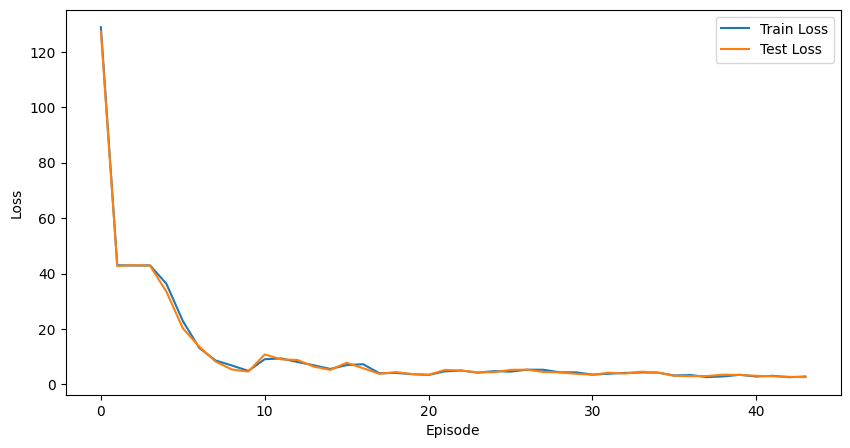

In [70]:
# Plot the losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.legend()
plt.show()
## MOST RECENT

## Visualise how well the NN predicts feature locations

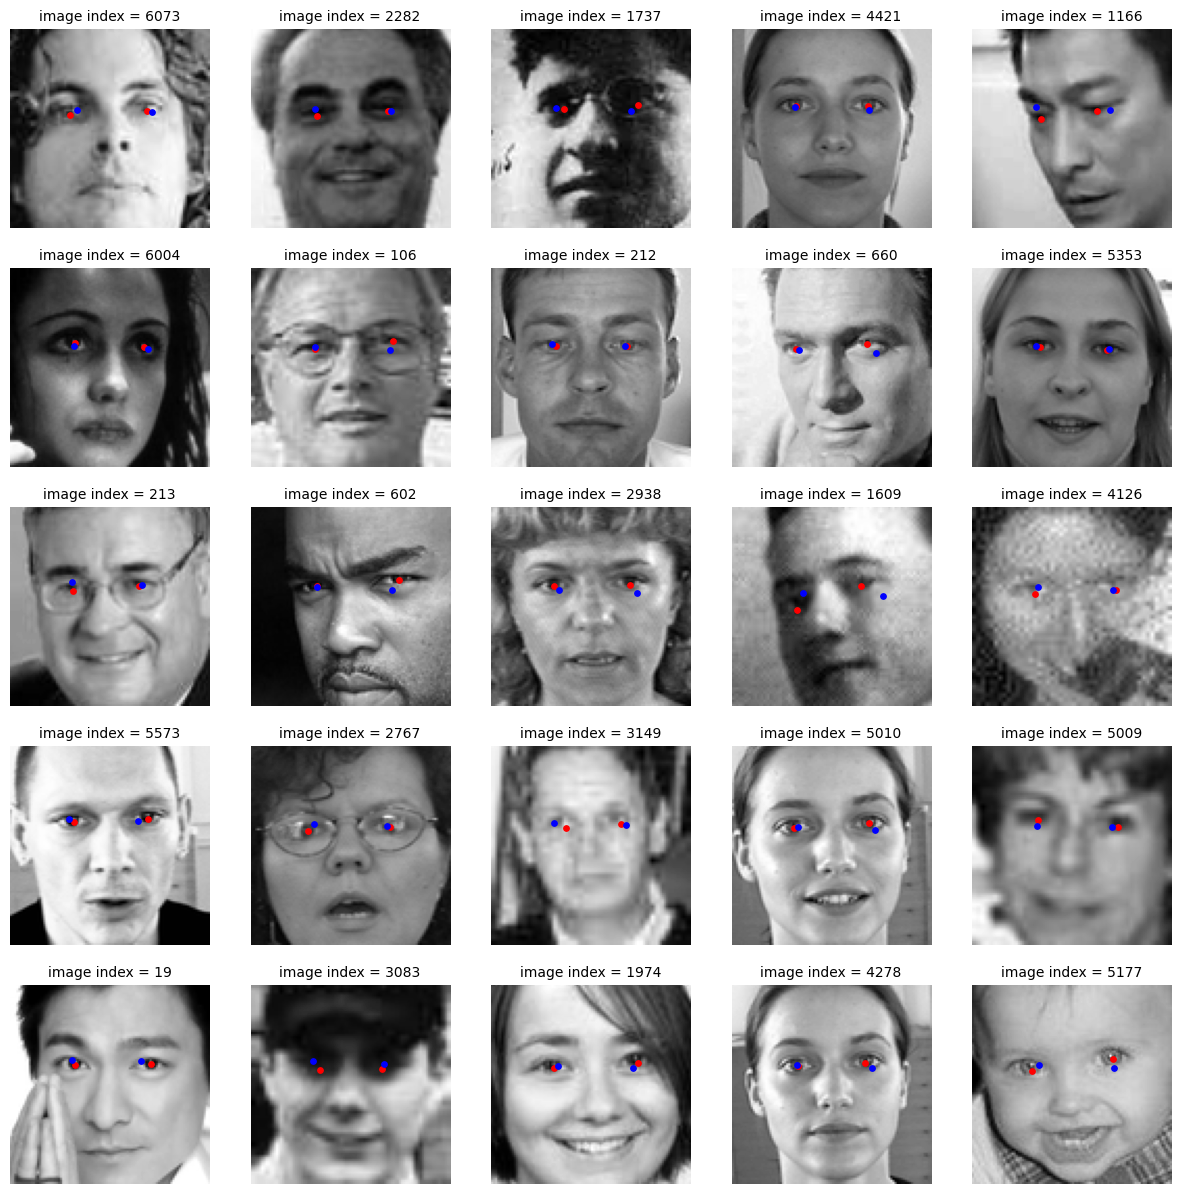

In [71]:
num_fig_rows = 5
num_fig_cols = 5

num_plots = num_fig_rows * num_fig_cols

rand_inds_vec = np.random.choice(test_images.shape[0],num_plots,replace=False)
rand_inds_mat = rand_inds_vec.reshape((num_fig_rows,num_fig_cols))

plt.close('all')
fig, ax = plt.subplots(nrows=num_fig_rows,ncols=num_fig_cols,figsize=(15,15))

for i in range(num_fig_rows):
    for j in range(num_fig_cols):
        curr_ind = rand_inds_mat[i][j]
        curr_image = test_images[curr_ind,0,:,:]
    
        x_true_coords = np.array(test_coords[curr_ind,0::2].tolist())
        y_true_coords = np.array(test_coords[curr_ind,1::2].tolist())
        
        with torch.no_grad():
            output = model(test_images[curr_ind,0,:,:].reshape(1,1,test_images.shape[2],test_images.shape[3]))
            x_pred_coords = output.detach().numpy()[0][0::2].tolist()
            y_pred_coords = output.detach().numpy()[0][1::2].tolist()
    
        ax[i][j].imshow(curr_image, cmap='gray')
        ax[i][j].scatter(x_true_coords,y_true_coords,c='r',s=15)
        ax[i][j].scatter(x_pred_coords,y_pred_coords,c='b',s=15)
        ax[i][j].set_axis_off()
        ax[i][j].set_title('image index = %d' %(curr_ind),fontsize=10)

## Run webcam through model

In [72]:
### Open the first webcam (index 0)
cap = cv2.VideoCapture(0)

# Check if the webcam is opened successfully
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

# Create OpenCV window
cv2.namedWindow("Webcam", cv2.WINDOW_NORMAL) 
# Resize window 
cv2.resizeWindow("Webcam", 300, 300) 
#########################################

model = CNN()
model.load_state_dict(torch.load('./model_trained'))
model.eval()

##########################################

# Loop to capture frames from the webcam
while True:
    # Read a frame from the webcam
    ret, frame = cap.read()

    # Check if frame is successfully read
    if not ret:
        print("Error: Failed to capture frame.")
        break

    # Process frame to be greyscale and same shape as training images
    image = cv2.resize(frame.mean(axis=2)[:,80:560], (0,0), fx=0.2, fy=0.2)/255.0
    
    # Forward pass through model to get coordinate predictions
    output = model(torch.tensor(np.reshape(image,(1,1,96,96))).float())
    x_pred_coords = output.detach().numpy()[0][0::2].astype(int)
    y_pred_coords = output.detach().numpy()[0][1::2].astype(int)
    
    # Draw coords on image
    imageDisplay = cv2.merge((image,image,image))
    for ix in range(len(x_pred_coords)):
        cv2.circle(imageDisplay, (x_pred_coords[ix], y_pred_coords[ix]), 2, (1.0, 0, 0), -1)

    # Display the image with coords
    cv2.imshow('Webcam', imageDisplay)

    # Check for 'q' key to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()


In [56]:
cap.release()
cv2.destroyAllWindows()